In [1]:
import pandas as pd
import numpy as np
import ipaddress
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
fraud_df = pd.read_csv(r"C://Users//Hiwi//Documents//week8&9//Fraud_Data.csv")
ip_df = pd.read_csv(r"C://Users//Hiwi//Documents//week8&9//IpAddress_to_Country.csv")
credit_df = pd.read_csv(r"C://Users//Hiwi//Documents//week8&9//creditcard.csv")

In [3]:
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

In [4]:
fraud_df.fillna({'browser': fraud_df['browser'].mode()[0]}, inplace=True)
fraud_df.dropna(inplace=True)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix, auc
# 1. Define features and target
X = fraud_df.drop(columns=['class', 'signup_time', 'purchase_time'])
y = fraud_df['class']

In [6]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Preprocessing
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [10]:
# 5. Logistic Regression Pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

logreg_pipeline.fit(X_train, y_train)
print(" Model training completed.")
y_pred_logreg = logreg_pipeline.predict(X_test)
print("\n Predicted class labels (first 10):\n", y_pred_logreg[:10])

# Predict class probabilities
y_proba_logreg = logreg_pipeline.predict_proba(X_test)[:, 1]
print("\n Predicted class probabilities for class 1 (first 10):\n", y_proba_logreg[:10])


 Model training completed.

 Predicted class labels (first 10):
 [0 0 0 0 0 0 0 0 0 0]

 Predicted class probabilities for class 1 (first 10):
 [0.06388852 0.06149296 0.13906747 0.0616869  0.07959197 0.07653783
 0.06176372 0.06620461 0.05719904 0.0591908 ]


In [11]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
# 6. XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])
xgb_pipeline.fit(X_train, y_train)
print(" XGBoost model training completed.")
y_pred_xgb = xgb_pipeline.predict(X_test)
print("\n XGBoost predicted class labels (first 10):\n", y_pred_xgb[:10])
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]
print("\n XGBoost predicted class probabilities for class 1 (first 10):\n", y_proba_xgb[:10])

C:\Users\Hiwi\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:36:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 XGBoost model training completed.

 XGBoost predicted class labels (first 10):
 [0 0 0 0 0 0 0 0 0 0]

 XGBoost predicted class probabilities for class 1 (first 10):
 [0.0807492  0.09415637 0.08633239 0.07603142 0.10009685 0.11612086
 0.06817006 0.07158124 0.07627584 0.0730201 ]


 99%|===================| 988/1000 [01:22<00:00]        

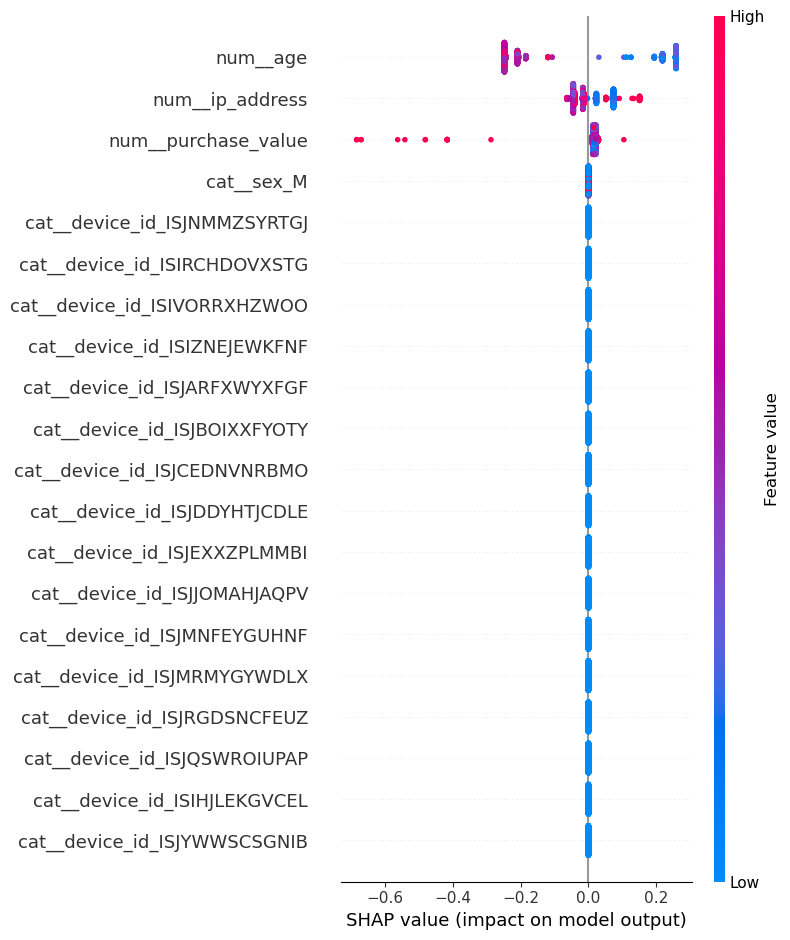

In [15]:
import shap
import matplotlib.pyplot as plt
import numpy as np

xgb_model = xgb_pipeline.named_steps['classifier']

# 1. Convert sparse matrix to dense (limit to 1000 rows for efficiency)
X_test_transformed = xgb_pipeline.named_steps['preprocessor'].transform(X_test)

X_sample = X_test_transformed[:1000].toarray()
# 2. Initialize SHAP TreeExplainer with the trained XGBoost model
explainer = shap.Explainer(xgb_model, X_sample)

# 3. Compute SHAP values
shap_values = explainer(X_sample)
feature_names = preprocessor.get_feature_names_out()
# 4. Plot SHAP summary (global feature importance)
shap.summary_plot(shap_values, X_sample, feature_names=feature_names)
